In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'

import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit
import numpy as np
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
import pandas as pd

gene_columns = ['geneNID', 'geneId', 'geneName', 'geneDescription', 'pLI', 'DSI', 'DPI']
disease_columns = ['diseaseNID', 'diseaseId', 'diseaseName', 'type']
disease2Class_columns = ['diseaseNID', 'diseaseClassNID']
diseaseClass_columns = ['diseaseClassNID', 'vocabulary', 'diseaseClass', 'diseaseClassName']
geneDiseaseNetwork_columns = ['NID', 'diseaseNID', 'geneNID', 'source', 'association', 'score', 'associationType', 'pmid']

diseaseAttributes = pd.read_csv('/home/naang/diseaseAttributes.csv', names=disease_columns, header=None)
geneAttributes = pd.read_csv('/home/naang/geneAttributes.csv', names=gene_columns, header=None)
disease2Class = pd.read_csv('/home/naang/disease2class.csv', names=disease2Class_columns, header=None)
diseaseClass = pd.read_csv('/home/naang/diseaseClass.csv', names=diseaseClass_columns, header=None)
geneDiseaseNetwork = pd.read_csv('/home/naang/geneDiseaseNetwork.csv', quotechar='"', escapechar="\\", dtype={6: str, 7: str})

gene_id_to_idx = {nid: idx for idx, nid in enumerate(sorted(geneAttributes['geneNID'].unique()))}
disease_id_to_idx = {nid: idx for idx, nid in enumerate(sorted(diseaseAttributes['diseaseNID'].unique()))}
disease_class_id_to_idx = {nid: idx for idx, nid in enumerate(sorted(diseaseClass['diseaseClassNID'].unique()))}

geneAttributes['geneNID'] = geneAttributes['geneNID'].map(gene_id_to_idx)
diseaseAttributes['diseaseNID'] = diseaseAttributes['diseaseNID'].map(disease_id_to_idx)
diseaseClass['diseaseClassNID'] = diseaseClass['diseaseClassNID'].map(disease_class_id_to_idx)
disease2Class['diseaseNID'] = disease2Class['diseaseNID'].map(disease_id_to_idx)
disease2Class['diseaseClassNID'] = disease2Class['diseaseClassNID'].map(disease_class_id_to_idx)

geneDiseaseNetwork['geneNID'] = geneDiseaseNetwork['geneNID'].map(gene_id_to_idx)
geneDiseaseNetwork['diseaseNID'] = geneDiseaseNetwork['diseaseNID'].map(disease_id_to_idx)

geneDiseaseNetwork = geneDiseaseNetwork.fillna(0)
geneDiseaseNetwork['pmid'] = geneDiseaseNetwork['pmid'].astype(int)

geneAttributes['geneName'] = geneAttributes['geneName'].fillna('unknown_gene')
geneAttributes['geneDescription'] = geneAttributes['geneDescription'].fillna('unknown_description')
geneAttributes['pLI'] = geneAttributes['pLI'].fillna(0)
geneAttributes['DSI'] = geneAttributes['DSI'].fillna(0)
geneAttributes['DPI'] = geneAttributes['DPI'].fillna(0)

source_encoder = LabelEncoder()
diseaseType_encoder = LabelEncoder()
associationType_encoder = LabelEncoder()
diseaseClass_encoder = LabelEncoder()
diseaseClassName_encoder = LabelEncoder()

geneDiseaseNetwork['source_encoded'] = source_encoder.fit_transform(geneDiseaseNetwork['source'])
diseaseAttributes['type_encoded'] = diseaseType_encoder.fit_transform(diseaseAttributes['type'])
diseaseClass['diseaseClass_encoded'] = diseaseClass_encoder.fit_transform(diseaseClass['diseaseClass'])
diseaseClass['diseaseClassName_encoded'] = diseaseClassName_encoder.fit_transform(diseaseClass['diseaseClassName'])
geneDiseaseNetwork['associationType_encoded'] = associationType_encoder.fit_transform(geneDiseaseNetwork['associationType'])

additional_classes = ['GeneDiseaseAssociation', 'SomaticModifyingMutation']
all_classes = list(associationType_encoder.classes_) + additional_classes
associationType_encoder.classes_ = np.array(all_classes)

print(f"[INFO] AssociationType Encoder extended with additional classes. Total classes: {len(associationType_encoder.classes_)}")

sentences_geneName = [name.split() for name in geneAttributes['geneName']]
sentences_geneDescription = [desc.split() for desc in geneAttributes['geneDescription']]
sentences_diseaseName = [name.split() for name in diseaseAttributes['diseaseName']]

word2vec_model = Word2Vec(sentences_geneName + sentences_geneDescription + sentences_diseaseName, vector_size=25, window=5, min_count=1, workers=4)

def get_vector(text):
    words = text.split()
    if any(word in word2vec_model.wv for word in words):
        return np.mean([word2vec_model.wv[word] for word in words if word in word2vec_model.wv], axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

geneAttributes['geneName_vec'] = geneAttributes['geneName'].apply(get_vector)
geneAttributes['geneDescription_vec'] = geneAttributes['geneDescription'].apply(get_vector)
diseaseAttributes['diseaseName_vec'] = diseaseAttributes['diseaseName'].apply(get_vector)

gene_features = np.column_stack([
    np.stack(geneAttributes['geneName_vec'].values),
    np.stack(geneAttributes['geneDescription_vec'].values),
    geneAttributes['pLI'].values,
    geneAttributes['DSI'].values,
    geneAttributes['DPI'].values
])

disease_features = np.column_stack([
    np.stack(diseaseAttributes['diseaseName_vec'].values),
    diseaseAttributes['type_encoded'].values
])

disease_class_features = np.column_stack((diseaseClass['diseaseClass_encoded'].values, diseaseClass['diseaseClassName_encoded'].values))

geneAttributes.drop(columns=['geneName', 'geneDescription'], inplace=True)
diseaseAttributes.drop(columns=['diseaseName'], inplace=True)
geneDiseaseNetwork.drop(columns=['sentence','EL','EI','year'], inplace=True)
diseaseClass.drop(columns=['vocabulary'], inplace=True)

data = HeteroData()

if gene_features.size > 0:
    gene_features_tensor = torch.tensor(gene_features, dtype=torch.float32)
    data['gene'].x = gene_features_tensor
    print(f"Gene features tensor assigned with shape: {data['gene'].x.shape}")
else:
    print("Gene features array is empty or malformed.")

if disease_features.size > 0:
    disease_features_tensor = torch.tensor(disease_features, dtype=torch.float32)
    data['disease'].x = disease_features_tensor
    print(f"Disease features tensor assigned with shape: {data['disease'].x.shape}")
else:
    print("Disease features array is empty or malformed.")

if disease_class_features.size > 0:
    disease_class_features_tensor = torch.tensor(disease_class_features, dtype=torch.float32)
    data['diseaseClass'].x = disease_class_features_tensor
    print(f"DiseaseClass features tensor assigned with shape: {data['diseaseClass'].x.shape}")
else:
    print("DiseaseClass features array is empty or malformed.")

if geneDiseaseNetwork[['geneNID', 'diseaseNID']].values.size > 0:
    edge_index_tensor = torch.tensor(geneDiseaseNetwork[['geneNID', 'diseaseNID']].values.T, dtype=torch.long)
    edge_attr_tensor = torch.tensor(geneDiseaseNetwork[['source_encoded', 'score', 'association', 'associationType_encoded', 'pmid']].values, dtype=torch.float)
    edge_label_tensor = torch.tensor(geneDiseaseNetwork['associationType_encoded'].values, dtype=torch.long)

    data['gene', 'associates', 'disease'].edge_index = edge_index_tensor
    data['gene', 'associates', 'disease'].edge_attr = edge_attr_tensor
    data['gene', 'associates', 'disease'].edge_label = edge_label_tensor

    print(f"Edge index tensor shape: {data['gene', 'associates', 'disease'].edge_index.shape}")
    print(f"Edge attribute tensor shape: {data['gene', 'associates', 'disease'].edge_attr.shape}")
    print(f"Edge label tensor shape: {data['gene', 'associates', 'disease'].edge_label.shape}")
else:
    print("Edge arrays are empty or malformed.")

if disease2Class[['diseaseNID', 'diseaseClassNID']].values.size > 0:
    disease_class_edge_index_tensor = torch.tensor(disease2Class[['diseaseNID', 'diseaseClassNID']].values.T, dtype=torch.long)
    data['disease', 'belongs_to', 'diseaseClass'].edge_index = disease_class_edge_index_tensor
    print(f"Disease-DiseaseClass edge index tensor shape: {data['disease', 'belongs_to', 'diseaseClass'].edge_index.shape}")
else:
    print("Disease-DiseaseClass edge arrays are empty or malformed.")

[INFO] AssociationType Encoder extended with additional classes. Total classes: 16
Gene features tensor assigned with shape: torch.Size([26137, 53])
Disease features tensor assigned with shape: torch.Size([30293, 26])
DiseaseClass features tensor assigned with shape: torch.Size([26, 2])
Edge index tensor shape: torch.Size([2, 3261324])
Edge attribute tensor shape: torch.Size([3261324, 5])
Edge label tensor shape: torch.Size([3261324])
Disease-DiseaseClass edge index tensor shape: torch.Size([2, 38324])


In [2]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import gc
from torch_geometric.data import HeteroData

def split_edge_data(data, target_column, test_size=0.2, val_size=0.1, random_state=42):
    edge_attr = data['gene', 'associates', 'disease'].edge_attr
    edge_label = data['gene', 'associates', 'disease'].edge_label
    edge_index = data['gene', 'associates', 'disease'].edge_index

    edge_attr_np = edge_attr.cpu().numpy()
    edge_label_np = edge_label.cpu().numpy()
    edge_index_np = edge_index.cpu().numpy()

    train_attr, temp_attr, train_label, temp_label, train_index, temp_index = train_test_split(
        edge_attr_np, edge_label_np, edge_index_np.T,
        test_size=(test_size + val_size), random_state=random_state, stratify=edge_label_np)

    val_size_adjusted = val_size / (test_size + val_size)

    val_attr, test_attr, val_label, test_label, val_index, test_index = train_test_split(
        temp_attr, temp_label, temp_index,
        test_size=(1 - val_size_adjusted), random_state=random_state, stratify=temp_label)

    train_attr = torch.tensor(train_attr, dtype=torch.float32)
    val_attr = torch.tensor(val_attr, dtype=torch.float32)
    test_attr = torch.tensor(test_attr, dtype=torch.float32)

    train_label = torch.tensor(train_label, dtype=torch.long)
    val_label = torch.tensor(val_label, dtype=torch.long)
    test_label = torch.tensor(test_label, dtype=torch.long)

    train_index = torch.tensor(train_index.T, dtype=torch.long)
    val_index = torch.tensor(val_index.T, dtype=torch.long)
    test_index = torch.tensor(test_index.T, dtype=torch.long)

    train_data = HeteroData()
    val_data = HeteroData()
    test_data = HeteroData()

    train_data['gene'].x = data['gene'].x.clone()
    train_data['disease'].x = data['disease'].x.clone()
    train_data['diseaseClass'].x = data['diseaseClass'].x.clone()

    val_data['gene'].x = data['gene'].x.clone()
    val_data['disease'].x = data['disease'].x.clone()
    val_data['diseaseClass'].x = data['diseaseClass'].x.clone()

    test_data['gene'].x = data['gene'].x.clone()
    test_data['disease'].x = data['disease'].x.clone()
    test_data['diseaseClass'].x = data['diseaseClass'].x.clone()

    train_data['gene', 'associates', 'disease'].edge_index = train_index
    train_data['gene', 'associates', 'disease'].edge_attr = train_attr
    train_data['gene', 'associates', 'disease'].edge_label = train_label

    val_data['gene', 'associates', 'disease'].edge_index = val_index
    val_data['gene', 'associates', 'disease'].edge_attr = val_attr
    val_data['gene', 'associates', 'disease'].edge_label = val_label

    test_data['gene', 'associates', 'disease'].edge_index = test_index
    test_data['gene', 'associates', 'disease'].edge_attr = test_attr
    test_data['gene', 'associates', 'disease'].edge_label = test_label

    disease_class_edge_index_tensor = data['disease', 'belongs_to', 'diseaseClass'].edge_index.clone()
    train_data['disease', 'belongs_to', 'diseaseClass'].edge_index = disease_class_edge_index_tensor
    val_data['disease', 'belongs_to', 'diseaseClass'].edge_index = disease_class_edge_index_tensor
    test_data['disease', 'belongs_to', 'diseaseClass'].edge_index = disease_class_edge_index_tensor

    return train_data, val_data, test_data

train_data, val_data, test_data = split_edge_data(data, 'associationType_encoded')

device = "cuda" if torch.cuda.is_available() else "cpu"
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [3]:
from sklearn.preprocessing import StandardScaler

def handle_nan_inf(tensor, name):
    if torch.isnan(tensor).any() or torch.isinf(tensor).any():
        print(f"NaNs or Infs detected in {name}. Replacing with zeros.")
        tensor = torch.where(torch.isnan(tensor) | torch.isinf(tensor), torch.tensor(0.0, device=tensor.device), tensor)
    return tensor

gene_features_tensor = handle_nan_inf(gene_features_tensor, "gene_features_tensor")
disease_features_tensor = handle_nan_inf(disease_features_tensor, "disease_features_tensor")
disease_class_features_tensor = handle_nan_inf(disease_class_features_tensor, "disease_class_features_tensor")

data = HeteroData()
data['gene'].x = gene_features_tensor
data['disease'].x = disease_features_tensor
data['diseaseClass'].x = disease_class_features_tensor

edge_index_tensor = torch.tensor(geneDiseaseNetwork[['geneNID', 'diseaseNID']].values.T, dtype=torch.long)
edge_attr_tensor = handle_nan_inf(torch.tensor(geneDiseaseNetwork[['source_encoded', 'score', 'association', 'associationType_encoded', 'pmid']].values, dtype=torch.float), "edge_attr_tensor")
edge_label_tensor = handle_nan_inf(torch.tensor(geneDiseaseNetwork['associationType_encoded'].values, dtype=torch.long), "edge_label_tensor")

data['gene', 'associates', 'disease'].edge_index = edge_index_tensor
data['gene', 'associates', 'disease'].edge_attr = edge_attr_tensor
data['gene', 'associates', 'disease'].edge_label = edge_label_tensor

disease_class_edge_index_tensor = torch.tensor(disease2Class[['diseaseNID', 'diseaseClassNID']].values.T, dtype=torch.long)
data['disease', 'belongs_to', 'diseaseClass'].edge_index = disease_class_edge_index_tensor

scaler = StandardScaler()

train_data['gene', 'associates', 'disease'].edge_attr = torch.tensor(
    scaler.fit_transform(train_data['gene', 'associates', 'disease'].edge_attr.cpu().numpy()), 
    dtype=torch.float32
).to(device)

val_data['gene', 'associates', 'disease'].edge_attr = torch.tensor(
    scaler.transform(val_data['gene', 'associates', 'disease'].edge_attr.cpu().numpy()), 
    dtype=torch.float32
).to(device)

test_data['gene', 'associates', 'disease'].edge_attr = torch.tensor(
    scaler.transform(test_data['gene', 'associates', 'disease'].edge_attr.cpu().numpy()), 
    dtype=torch.float32
).to(device)

del data
torch.cuda.empty_cache()
gc.collect()

print(device)

cuda


In [4]:
encoded_to_name = geneDiseaseNetwork[['associationType_encoded', 'associationType']].drop_duplicates().set_index('associationType_encoded')['associationType'].to_dict()

class_distribution = geneDiseaseNetwork['associationType_encoded'].value_counts().sort_index()

print("Class distribution with association type names:")
for encoded_value, count in class_distribution.items():
    association_name = encoded_to_name.get(encoded_value, "Unknown")
    print(f"{encoded_value} ({association_name}): {count}")

Class distribution with association type names:
0 (AlteredExpression): 638378
1 (Biomarker): 1708286
2 (CausalMutation): 65588
3 (ChromosomalRearrangement): 223
4 (FusionGene): 315
5 (GeneticVariation): 800444
6 (GenomicAlterations): 397
7 (GermlineCausalMutation): 6275
8 (GermlineModifyingMutation): 65
9 (ModifyingMutation): 326
10 (PosttranslationalModification): 28738
11 (SomaticCausalMutation): 285
12 (SusceptibilityMutation): 1260
13 (Therapeutic): 10744


In [5]:
import logging
from torch_geometric.data import HeteroData

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def log_data_sizes(train_data: HeteroData, val_data: HeteroData, test_data: HeteroData):
    train_edges = train_data['gene', 'associates', 'disease'].edge_index.size(1)
    train_labels = train_data['gene', 'associates', 'disease'].edge_label.size(0)

    logger.info(f"Tanító adathalmaz: élek száma = {train_edges}, címkék száma = {train_labels}")

    val_edges = val_data['gene', 'associates', 'disease'].edge_index.size(1)
    val_labels = val_data['gene', 'associates', 'disease'].edge_label.size(0)
    logger.info(f"Validációs adathalmaz: élek száma = {val_edges}, címkék száma = {val_labels}")

    test_edges = test_data['gene', 'associates', 'disease'].edge_index.size(1)
    test_labels = test_data['gene', 'associates', 'disease'].edge_label.size(0)
    logger.info(f"Teszthalmaz: élek száma = {test_edges}, címkék száma = {test_labels}")

log_data_sizes(train_data, val_data, test_data)

2024-10-27 00:52:33,935 - INFO - Tanító adathalmaz: élek száma = 2282926, címkék száma = 2282926
2024-10-27 00:52:33,936 - INFO - Validációs adathalmaz: élek száma = 326132, címkék száma = 326132
2024-10-27 00:52:33,937 - INFO - Teszthalmaz: élek száma = 652266, címkék száma = 652266


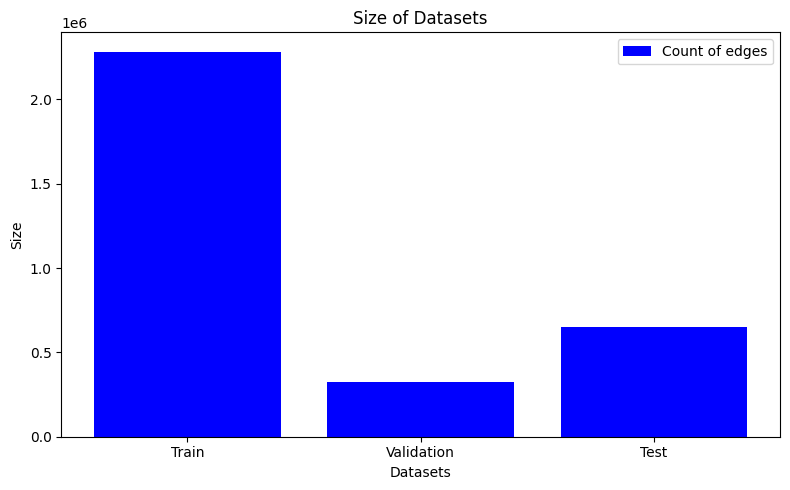

In [6]:
import matplotlib.pyplot as plt

datasets = ['Train', 'Validation', 'Test']
edges = [2282926, 326132, 652266]

plt.figure(figsize=(8, 5))
plt.bar(datasets, edges, color='b', label='Count of edges')

plt.title('Size of Datasets')
plt.xlabel('Datasets')
plt.ylabel('Size')
plt.legend()
plt.tight_layout()

plt.show()

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, gene_feature_dim, disease_feature_dim, disease_class_feature_dim, edge_feature_dim, dropout=0.3):
        super(HeteroGNN, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(HeteroConv({
            ('gene', 'associates', 'disease'): SAGEConv((gene_feature_dim, disease_feature_dim), hidden_channels),
            ('disease', 'rev_associates', 'gene'): SAGEConv((disease_feature_dim, gene_feature_dim), hidden_channels),
            ('disease', 'belongs_to', 'diseaseClass'): SAGEConv((disease_feature_dim, disease_class_feature_dim), hidden_channels),
            ('diseaseClass', 'rev_belongs_to', 'disease'): SAGEConv((disease_class_feature_dim, disease_feature_dim), hidden_channels)
        }, aggr='mean'))

        self.gene_lin = Linear(gene_feature_dim, hidden_channels)
        self.disease_lin = Linear(disease_feature_dim, hidden_channels)
        self.disease_class_lin = Linear(disease_class_feature_dim, hidden_channels)
        self.edge_lin = Linear(edge_feature_dim, hidden_channels)

        self.lin = Linear(hidden_channels * 3, len(associationType_encoder.classes_))

        self.dropout = dropout

        self.reset_parameters()

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        self.gene_lin.reset_parameters()
        self.disease_lin.reset_parameters()
        self.disease_class_lin.reset_parameters()
        self.edge_lin.reset_parameters()
        self.lin.reset_parameters()

    def forward(self, x_dict, edge_index_dict):
        x_dict['gene'] = F.relu(self.gene_lin(x_dict['gene']))
        x_dict['disease'] = F.relu(self.disease_lin(x_dict['disease']))
        x_dict['diseaseClass'] = F.relu(self.disease_class_lin(x_dict['diseaseClass']))

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.relu(F.dropout(x, p=self.dropout, training=self.training)) for key, x in x_dict.items()}

        return x_dict

    def decode(self, x_dict, edge_index, edge_attr):
        source_embeddings = x_dict['gene'][edge_index[0]]
        target_embeddings = x_dict['disease'][edge_index[1]]

        edge_attr_transformed = F.relu(self.edge_lin(edge_attr))

        source_embeddings_transformed = F.relu(self.gene_lin(source_embeddings))
        target_embeddings_transformed = F.relu(self.disease_lin(target_embeddings))

        edge_embeddings = torch.cat([source_embeddings_transformed, target_embeddings_transformed, edge_attr_transformed], dim=1)

        return self.lin(F.dropout(edge_embeddings, p=self.dropout, training=self.training))

gene_feature_dim = train_data['gene'].x.size(1)
disease_feature_dim = train_data['disease'].x.size(1)
disease_class_feature_dim = train_data['diseaseClass'].x.size(1)
edge_feature_dim = train_data['gene', 'associates', 'disease'].edge_attr.size(1)
hidden_channels = 256

model = HeteroGNN(train_data.metadata(), hidden_channels=hidden_channels, gene_feature_dim=gene_feature_dim, disease_feature_dim=disease_feature_dim, edge_feature_dim=edge_feature_dim, disease_class_feature_dim=disease_class_feature_dim, dropout=0.5).to(device)

In [6]:
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
from itertools import cycle
from sklearn.preprocessing import label_binarize

def plot_confusion_matrix(labels, preds, class_names, title="Confusion Matrix", max_classes=50):
    if len(class_names) > max_classes:
        print(f"[INFO] Confusion matrix too large, limiting to {max_classes} most frequent classes.")
        class_names = class_names[:max_classes]
        labels = np.clip(labels, 0, max_classes - 1)
        preds = np.clip(preds, 0, max_classes - 1)
    
    cm = confusion_matrix(labels, preds, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap='Blues')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.title(title)
    plt.show()

from sklearn.utils import resample

def calculate_metrics_on_sample(all_preds, all_labels, sample_size=10000):
    if len(all_preds) > sample_size:
        all_preds, all_labels = resample(all_preds, all_labels, n_samples=sample_size, random_state=42)
    
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    
    return precision, recall, f1, mcc, kappa

def format_large_numbers(value):
    if value >= 1e6:
        return f'{value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'{value / 1e3:.1f}K'
    else:
        return str(value)

def plot_class_distribution(geneDiseaseNetwork, encoded_to_name):
    class_distribution = geneDiseaseNetwork['associationType_encoded'].value_counts().sort_index()
    class_counts = class_distribution.to_dict()

    classes = list(class_counts.keys())
    counts = np.array(list(class_counts.values()))
    total_count = counts.sum()

    x = np.arange(len(classes))
    class_names = [encoded_to_name.get(c, f'Class {c}') for c in classes]

    fig, ax = plt.subplots(figsize=(14, 8))

    width = 0.35
    bars = ax.bar(x, counts, width, label='Count', color='blue')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Counts')
    ax.set_title('Class Counts per Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=90)
    ax.legend()

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.annotate(format_large_numbers(count),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    fig.tight_layout()

    plt.show()

def plot_class_accuracies(train_class_acc, val_class_acc, test_class_acc, num_classes, encoded_to_name):
    valid_classes = np.arange(num_classes - 2)
    class_names = [encoded_to_name.get(c, f'Class {c}') for c in valid_classes]

    train_acc = np.array([train_class_acc.get(f'Class {c}', 0) for c in valid_classes])
    val_acc = np.array([val_class_acc.get(f'Class {c}', 0) for c in valid_classes])
    test_acc = np.array([test_class_acc.get(f'Class {c}', 0) for c in valid_classes])

    x = np.arange(len(valid_classes))

    fig, ax = plt.subplots(figsize=(14, 8))

    width = 0.2
    ax.bar(x - width, train_acc, width, label='Train Class Accuracy', color='orange')
    ax.bar(x, val_acc, width, label='Val Class Accuracy', color='green')
    ax.bar(x + width, test_acc, width, label='Test Class Accuracy', color='red')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Accuracy')
    ax.set_title('Class Accuracies per Class')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_ylim(0, 1)
    ax.legend()

    fig.tight_layout()

    plt.show()

def plot_class_accuracies_per_classes(metrics, num_classes, class_names):
    epochs = range(1, len(metrics['train_loss']) + 1)
    
    for class_idx in range(num_classes):
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, metrics['train_class_acc'][class_idx], label='Train', color='blue')
        plt.plot(epochs, metrics['val_class_acc'][class_idx], label='Validation', color='orange')
        plt.plot(epochs, metrics['test_class_acc'][class_idx], label='Test', color='green')
        plt.title(f'Accuracy Progression for {class_names.get(class_idx, f"Class {class_idx}")}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def accuracy_per_class(preds, labels, num_classes):
    class_correct = torch.zeros(num_classes, device=device)
    class_total = torch.zeros(num_classes, device=device)

    preds = preds.view(-1)
    labels = labels.view(-1)

    for c in range(num_classes):
        class_mask = (labels == c)
        class_correct[c] = (preds[class_mask] == labels[class_mask]).float().sum()
        class_total[c] = class_mask.sum()

    class_accuracy = torch.where(class_total > 0, class_correct / class_total, torch.tensor(0.0, device=device))
    class_accuracy_dict = {f'Class {i}': class_accuracy[i].item() for i in range(num_classes)}
    return class_accuracy_dict

def plot_precision_recall_curve(labels, preds, num_classes, title):
    labels = labels.cpu().numpy()
    preds = preds.detach().cpu().numpy()

    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0, 1, num_classes)]

    plt.figure(figsize=(10, 8))
    for i, color in zip(range(num_classes), colors):
        true_binary = (labels == i).astype(int)
        pred_binary = (preds == i).astype(int)
        precision, recall, _ = precision_recall_curve(true_binary, pred_binary)
        average_precision = average_precision_score(true_binary, pred_binary)
        class_name = encoded_to_name.get(i, f'Class {i}')
        plt.plot(recall, precision, color=color, lw=2,
                 label=f'{class_name} (AP: {average_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{title}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    plt.tight_layout()
    plt.show()

def plot_training_metrics(metrics):
    epochs = range(len(metrics['train_loss']))

    plt.figure(figsize=(18, 12))

    plt.subplot(3, 3, 1)
    plt.plot(epochs, metrics['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics['val_loss'], label='Val Loss')
    plt.plot(epochs, metrics['test_loss'], label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 3, 2)
    plt.plot(epochs, metrics['train_acc'], label='Train Accuracy')
    plt.plot(epochs, metrics['val_acc'], label='Val Accuracy')
    plt.plot(epochs, metrics['test_acc'], label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 3, 3)
    plt.plot(epochs, metrics['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics['val_precision'], label='Val Precision')
    plt.plot(epochs, metrics['test_precision'], label='Test Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(3, 3, 4)
    plt.plot(epochs, metrics['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics['val_recall'], label='Val Recall')
    plt.plot(epochs, metrics['test_recall'], label='Test Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(3, 3, 5)
    plt.plot(epochs, metrics['train_f1'], label='Train F1 Score')
    plt.plot(epochs, metrics['val_f1'], label='Val F1 Score')
    plt.plot(epochs, metrics['test_f1'], label='Test F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.subplot(3, 3, 6)
    plt.plot(epochs, metrics['train_mcc'], label='Train MCC')
    plt.plot(epochs, metrics['val_mcc'], label='Val MCC')
    plt.plot(epochs, metrics['test_mcc'], label='Test MCC')
    plt.xlabel('Epochs')
    plt.ylabel('MCC')
    plt.legend()

    plt.subplot(3, 3, 7)
    plt.plot(epochs, metrics['train_kappa'], label='Train Kappa')
    plt.plot(epochs, metrics['val_kappa'], label='Val Kappa')
    plt.plot(epochs, metrics['test_kappa'], label='Test Kappa')
    plt.xlabel('Epochs')
    plt.ylabel('Cohen\'s Kappa')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
train_labels = train_data['gene', 'associates', 'disease'].edge_label.cpu().numpy()

unique_classes, class_counts = np.unique(train_labels, return_counts=True)

class_distribution_train = dict(zip(unique_classes, class_counts))

print(class_distribution_train)

{0: 446864, 1: 1195800, 2: 45912, 3: 156, 4: 220, 5: 560311, 6: 278, 7: 4392, 8: 46, 9: 228, 10: 20117, 11: 199, 12: 882, 13: 7521}


In [8]:
hierarchy = {
    'root': 'GeneDiseaseAssociation',
    'GeneDiseaseAssociation': {'children': ['Therapeutic', 'Biomarker']},
    'Biomarker': {'children': ['GenomicAlterations', 'AlteredExpression', 'PosttranslationalModification']},
    'GenomicAlterations': {'children': ['ChromosomalRearrangement', 'GeneticVariation', 'FusionGene']},
    'GeneticVariation': {'children': ['CausalMutation', 'ModifyingMutation', 'SusceptibilityMutation']},
    'CausalMutation': {'children': ['SomaticCausalMutation', 'GermlineCausalMutation']},
    'ModifyingMutation': {'children': ['SomaticModifyingMutation', 'GermlineModifyingMutation']},
}

def calculate_thresholds(class_distribution_train, threshold_controller):
    thresholds = {}
    for class_name, count in class_distribution_train.items():
        if count > 0:
            thresholds[class_name] = 1 / (count ** threshold_controller)
        else:
            thresholds[class_name] = 0.1
    return thresholds

threshold_controller = 2.0

new_thresholds = calculate_thresholds(class_distribution_train, threshold_controller)
min_threshold = min(new_thresholds.values())

new_thresholds[14] = min_threshold
new_thresholds[15] = min_threshold

In [9]:
import time
import torch.nn.functional as F

def extend_label_encoder(encoder, hierarchy):
    all_classes = set()

    def extract_classes(node):
        all_classes.add(node)
        if 'children' in hierarchy.get(node, {}):
            for child in hierarchy[node]['children']:
                extract_classes(child)

    extract_classes(hierarchy['root'])

    all_classes.update(encoder.classes_)
    encoder.classes_ = np.array(list(all_classes))
    print(f"[INFO] LabelEncoder extended with {len(all_classes)} classes.")

extend_label_encoder(associationType_encoder, hierarchy)

def hierarchical_classification(pred, hierarchy, new_thresholds, class_encoder, chunk_size=100000):
    start_time = time.time()

    confidence = torch.softmax(pred, dim=1)
    batch_size = confidence.size(0)
    num_classes = confidence.size(1)
    device = confidence.device

    class_names = class_encoder.classes_
    class_thresholds = torch.tensor([new_thresholds.get(name, 0.1) for name in class_names], device=device)

    final_labels = torch.empty(batch_size, device=device, dtype=torch.long)

    reported_nodes = set()

    with torch.no_grad():
        for batch_start in range(0, batch_size, chunk_size):
            batch_end = min(batch_start + chunk_size, batch_size)
            batch_indices = torch.arange(batch_start, batch_end, device=device)

            root_encoded_idx = class_encoder.transform([hierarchy['root']])[0]
            current_nodes = torch.full((batch_end - batch_start,), fill_value=root_encoded_idx, device=device)

            iteration = 0
            stop_mask = torch.zeros_like(current_nodes, dtype=torch.bool)

            while True:
                iteration += 1

                current_nodes = torch.clamp(current_nodes, 0, num_classes - 1)

                current_confidence = torch.gather(confidence[batch_indices], 1, current_nodes.view(-1, 1)).squeeze(1)

                adjusted_thresholds = class_thresholds * 0.9
                current_thresholds = adjusted_thresholds[current_nodes]
                stop_mask = stop_mask | (current_confidence < current_thresholds)

                if stop_mask.all():
                    break

                final_labels[batch_indices][stop_mask] = current_nodes[stop_mask]

                continue_mask = ~stop_mask
                if continue_mask.sum() == 0:
                    break

                child_class_indices = []
                for node in current_nodes[continue_mask]:
                    current_node_name = class_encoder.inverse_transform([node.item()])[0]
                    children = hierarchy.get(current_node_name, {}).get('children')

                    if not children:
                        stop_mask[continue_mask] = True
                        final_labels[batch_indices][continue_mask] = current_nodes[continue_mask]
                        child_class_indices.append([])
                    else:
                        child_class_names = children
                        child_class_indices.append(class_encoder.transform(child_class_names).tolist())

                if len(child_class_indices) == 0:
                    break

                max_child_indices = torch.zeros_like(current_nodes[continue_mask])
                max_children_count = max(len(indices) for indices in child_class_indices)
                child_class_indices_padded = torch.full((len(child_class_indices), max_children_count), fill_value=-1, device=device)

                for i, child_indices in enumerate(child_class_indices):
                    if len(child_indices) > 0:
                        child_class_indices_padded[i, :len(child_indices)] = torch.tensor(child_indices, device=device)

                valid_mask = (child_class_indices_padded >= 0) & (child_class_indices_padded < num_classes)
                safe_child_class_indices = child_class_indices_padded.clone()
                safe_child_class_indices[~valid_mask] = 0

                if safe_child_class_indices.size(1) == 0 or valid_mask.sum() == 0:
                    final_labels[batch_indices][continue_mask] = current_nodes[continue_mask]
                    break

                if continue_mask.sum() > 0:
                    current_conf = confidence[batch_indices][continue_mask].gather(1, safe_child_class_indices.long())
                    current_conf = current_conf * valid_mask.float()

                    if current_conf.size(1) == 0:
                        break

                    max_child_idx = current_conf.argmax(dim=1)
                    for i in range(max_child_indices.size(0)):
                        max_child_indices[i] = safe_child_class_indices[i, max_child_idx[i]]

                    current_nodes[continue_mask] = max_child_indices

            final_labels[batch_indices][~stop_mask] = current_nodes[~stop_mask]

    final_labels = confidence.argmax(dim=1)

    print(f"[DEBUG] Hierarchical classification completed in {time.time() - start_time:.4f} seconds.")
    return final_labels.to(pred.device)

[INFO] LabelEncoder extended with 16 classes.


In [10]:
print(f"Class labels in associationType_encoder: {associationType_encoder.classes_}")

print(f"Number of classes: {len(associationType_encoder.classes_)}")

Class labels in associationType_encoder: ['SomaticModifyingMutation' 'GenomicAlterations' 'SomaticCausalMutation'
 'ModifyingMutation' 'GermlineModifyingMutation' 'FusionGene'
 'SusceptibilityMutation' 'GeneDiseaseAssociation'
 'ChromosomalRearrangement' 'Biomarker' 'GermlineCausalMutation'
 'Therapeutic' 'AlteredExpression' 'CausalMutation' 'GeneticVariation'
 'PosttranslationalModification']
Number of classes: 16



[INFO] Starting epoch 1/2001
[DEBUG] Hierarchical classification completed in 22.1774 seconds.
[INFO] Batch 1/1 processed in 22.7075 seconds. Loss: 2.8393
[DEBUG] Hierarchical classification completed in 0.0042 seconds.
[DEBUG] Hierarchical classification completed in 0.0070 seconds.
Epoch 1 completed in 23.06 seconds.
Train Loss: 2.8393, Acc: 0.0535, Precision: 0.4586, Recall: 0.0531, F1: 0.0676, MCC: 0.0215, Kappa: 0.0164
Train Class Acc: {'Class 0': '0.1701', 'Class 1': '0.0053', 'Class 2': '0.1834', 'Class 3': '0.0000', 'Class 4': '0.0727', 'Class 5': '0.0520', 'Class 6': '0.1619', 'Class 7': '0.0346', 'Class 8': '0.0217', 'Class 9': '0.0000', 'Class 10': '0.0606', 'Class 11': '0.0201', 'Class 12': '0.0147', 'Class 13': '0.0973'}
Val Loss: 1.8434, Acc: 0.5449, Precision: 0.4509, Recall: 0.5524, F1: 0.4151, MCC: 0.1588, Kappa: 0.0676
Val Class Acc: {'Class 0': '0.0000', 'Class 1': '1.0000', 'Class 2': '0.0000', 'Class 3': '0.0000', 'Class 4': '0.0000', 'Class 5': '0.0858', 'Class 6

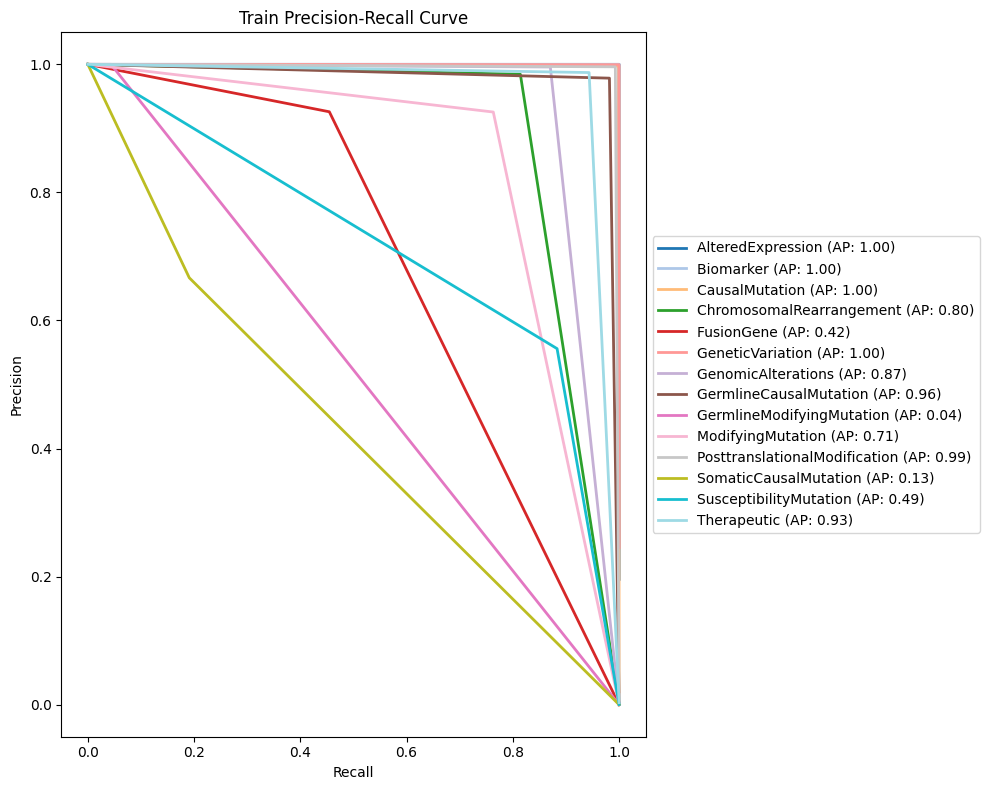

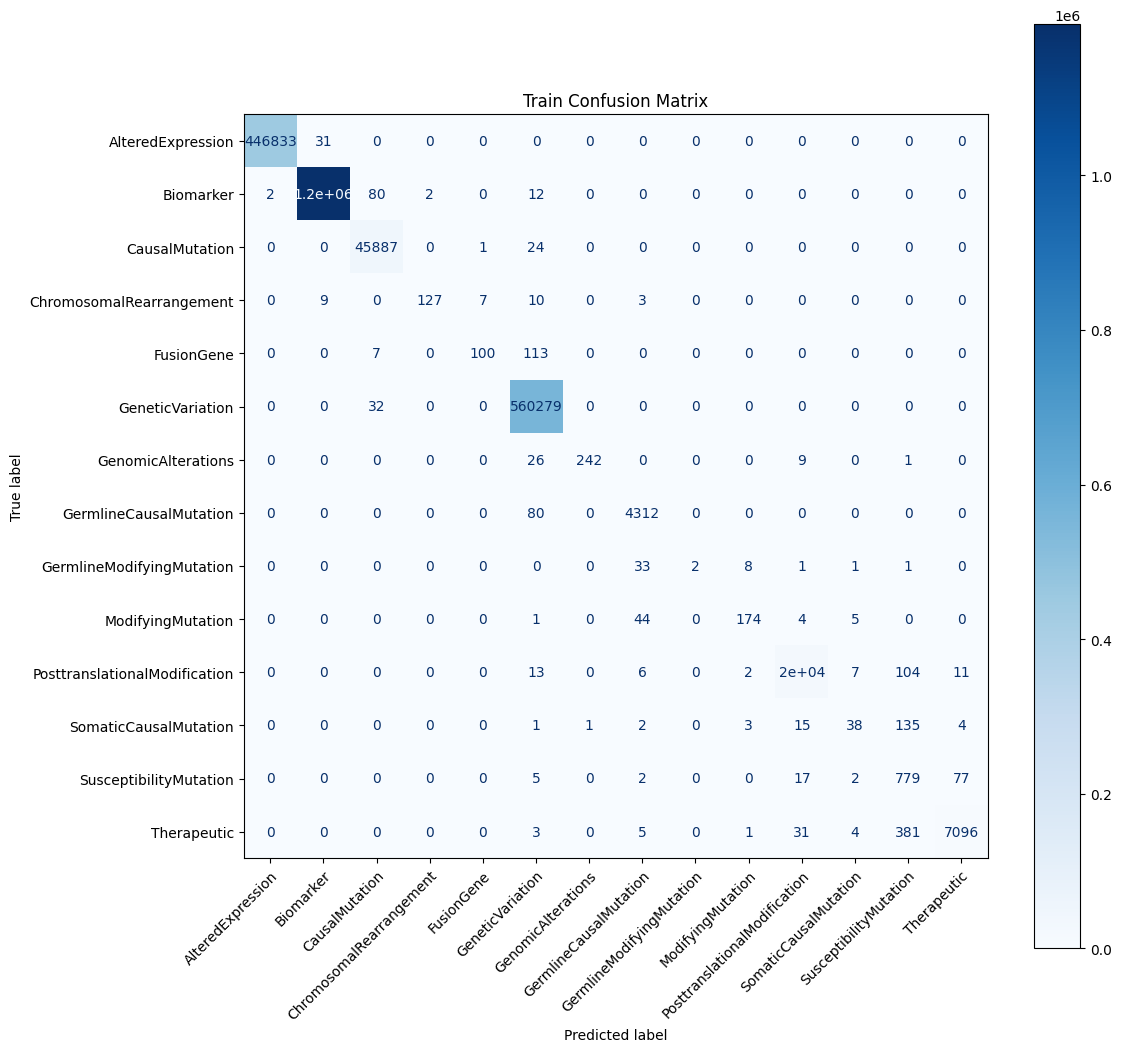

[DEBUG] Hierarchical classification completed in 0.2797 seconds.


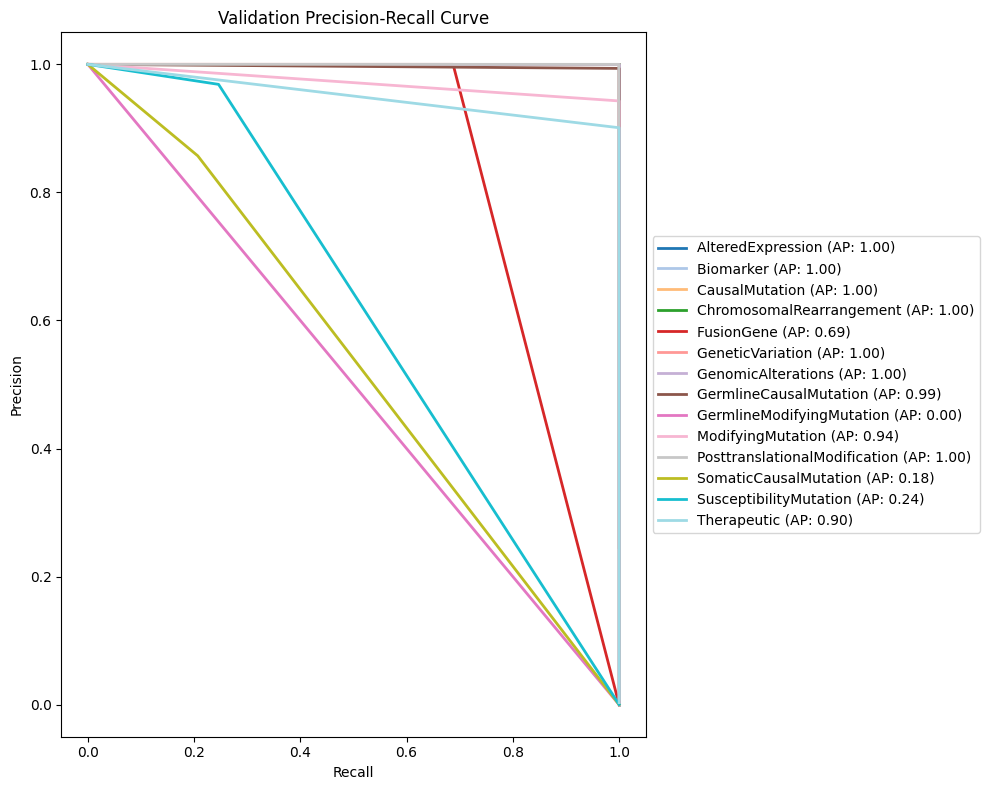

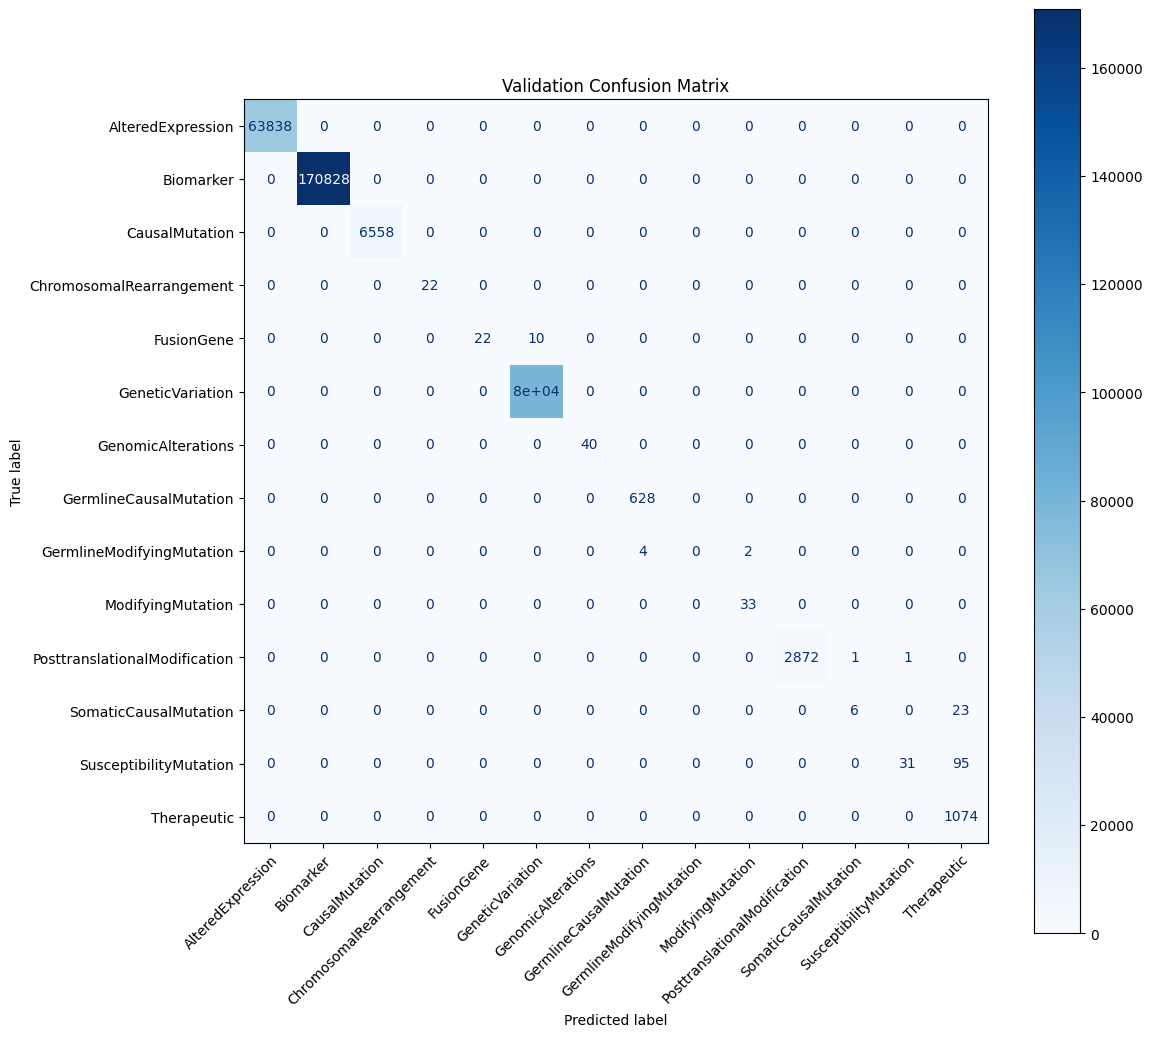

[DEBUG] Hierarchical classification completed in 0.5586 seconds.


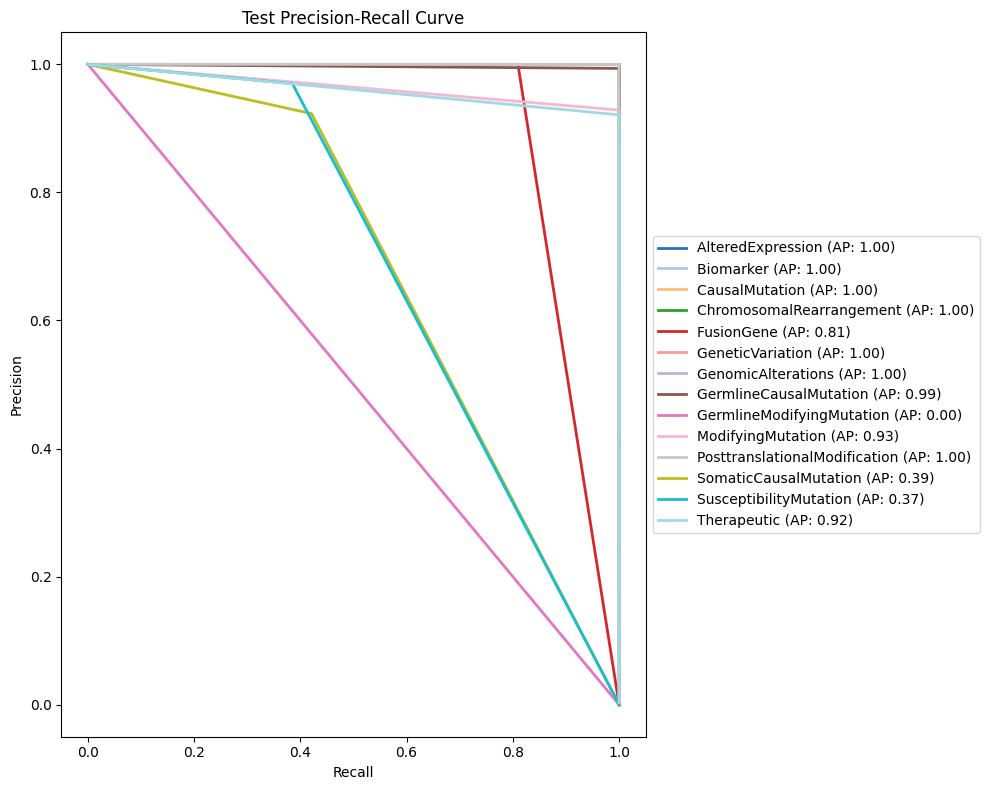

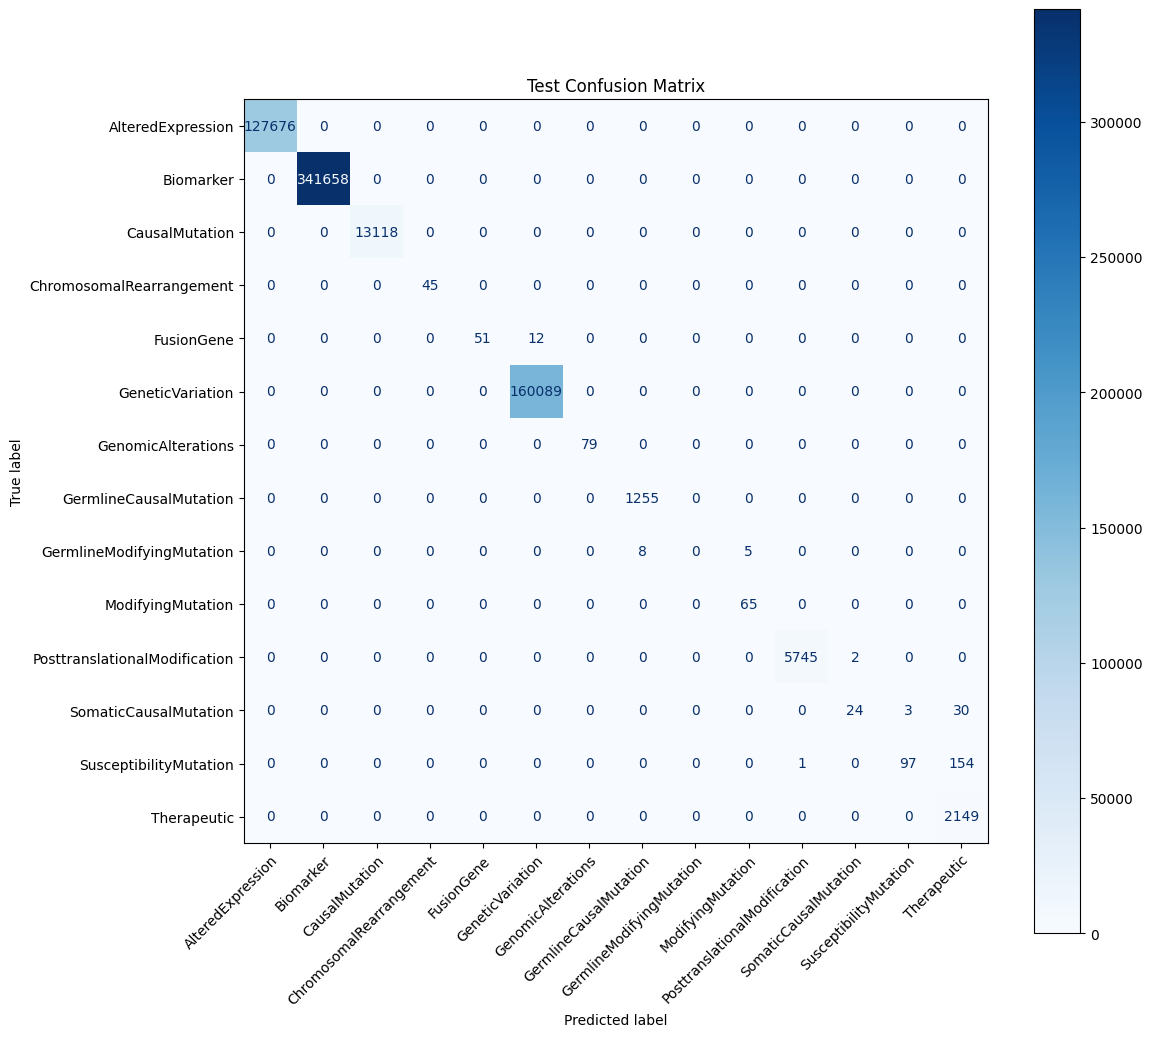

Epoch 2001 completed in 16.26 seconds.
Train Loss: 0.0021, Acc: 0.9994, Precision: 0.9993, Recall: 0.9992, F1: 0.9992, MCC: 0.9987, Kappa: 0.9987
Train Class Acc: {'Class 0': '0.9999', 'Class 1': '0.9999', 'Class 2': '0.9995', 'Class 3': '0.8141', 'Class 4': '0.4545', 'Class 5': '0.9999', 'Class 6': '0.8705', 'Class 7': '0.9818', 'Class 8': '0.0435', 'Class 9': '0.7632', 'Class 10': '0.9929', 'Class 11': '0.1910', 'Class 12': '0.8832', 'Class 13': '0.9435'}
Val Loss: 0.0011, Acc: 0.9996, Precision: 0.9993, Recall: 0.9994, F1: 0.9992, MCC: 0.9990, Kappa: 0.9990
Val Class Acc: {'Class 0': '1.0000', 'Class 1': '1.0000', 'Class 2': '1.0000', 'Class 3': '1.0000', 'Class 4': '0.6875', 'Class 5': '1.0000', 'Class 6': '1.0000', 'Class 7': '1.0000', 'Class 8': '0.0000', 'Class 9': '1.0000', 'Class 10': '0.9993', 'Class 11': '0.2069', 'Class 12': '0.2460', 'Class 13': '1.0000'}
Test Loss: 0.0010, Test Acc: 0.9997, Precision: 0.9996, Recall: 0.9995, F1: 0.9994, MCC: 0.9992, Kappa: 0.9992
Test Cla

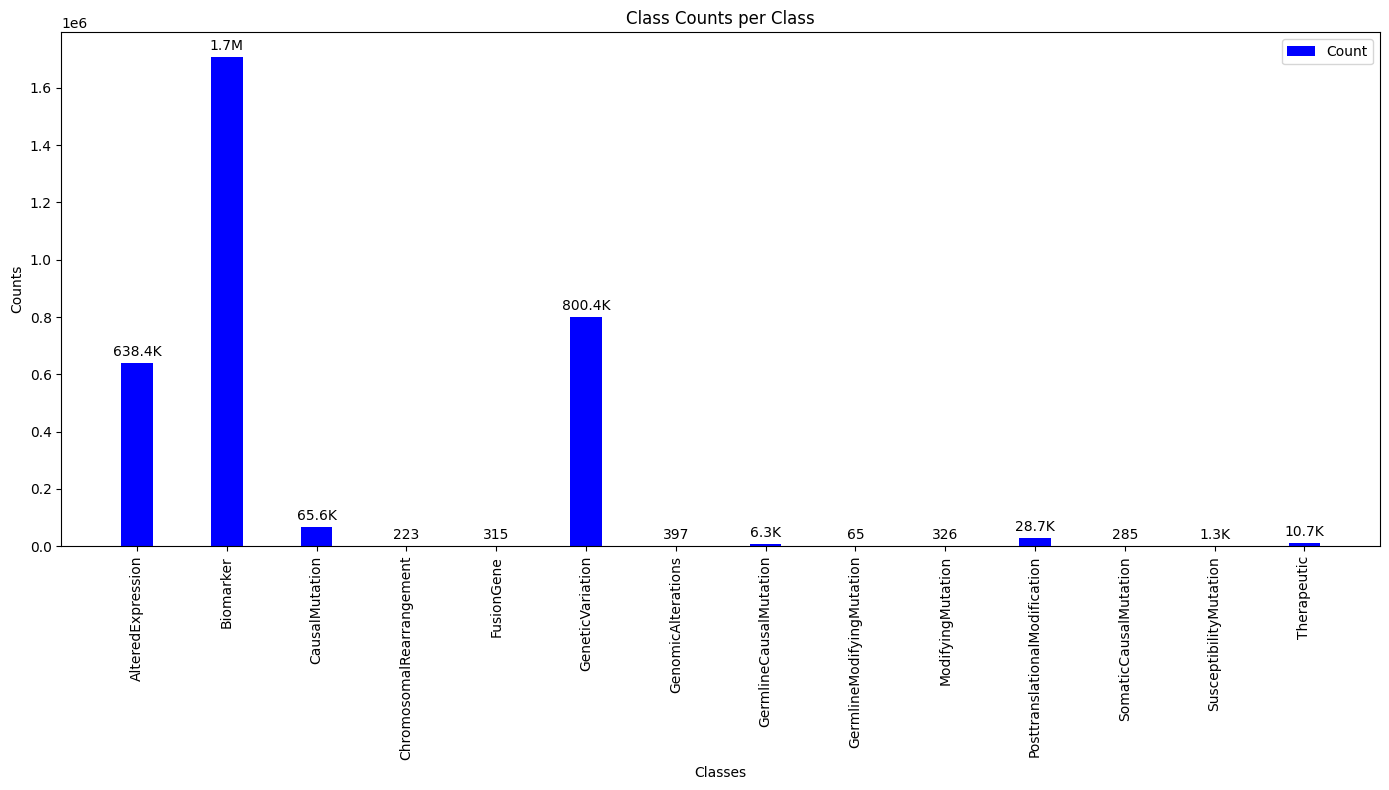

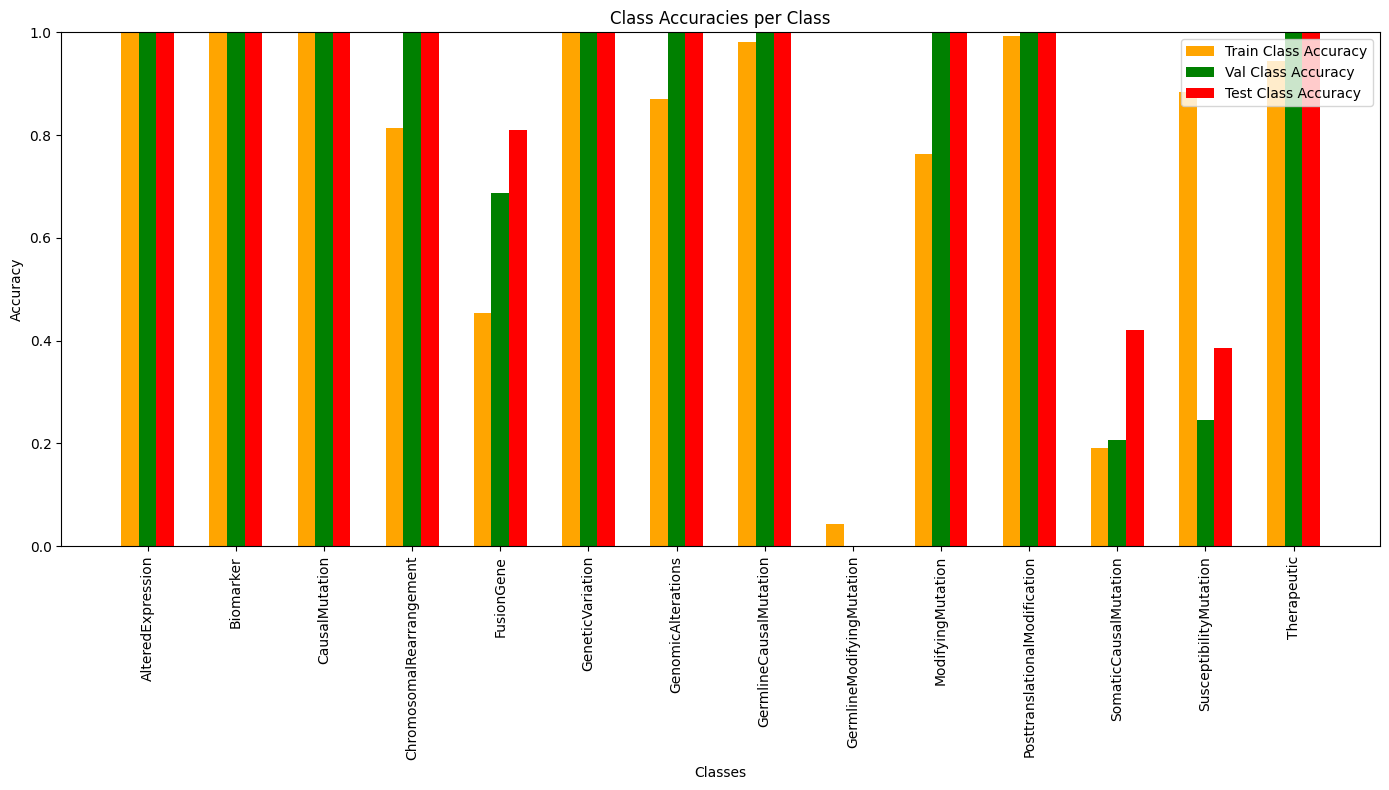

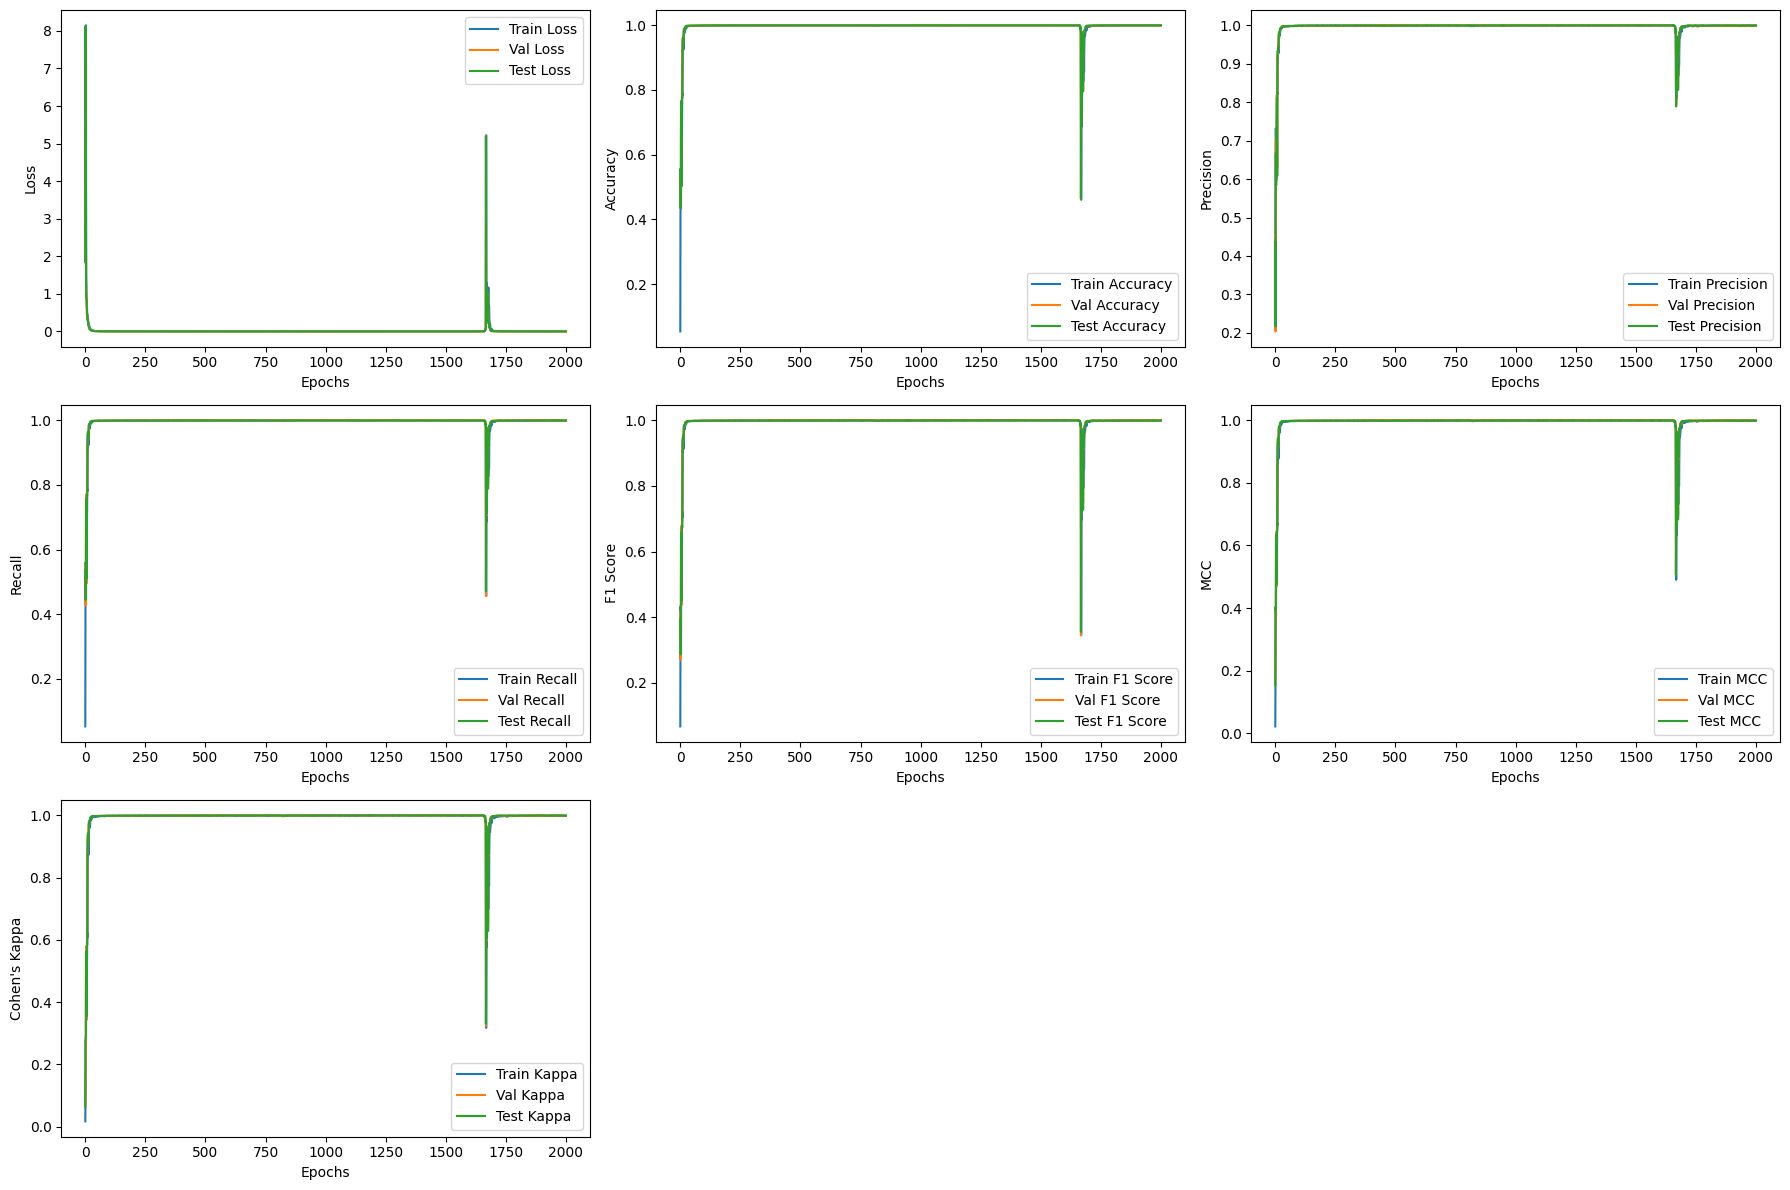

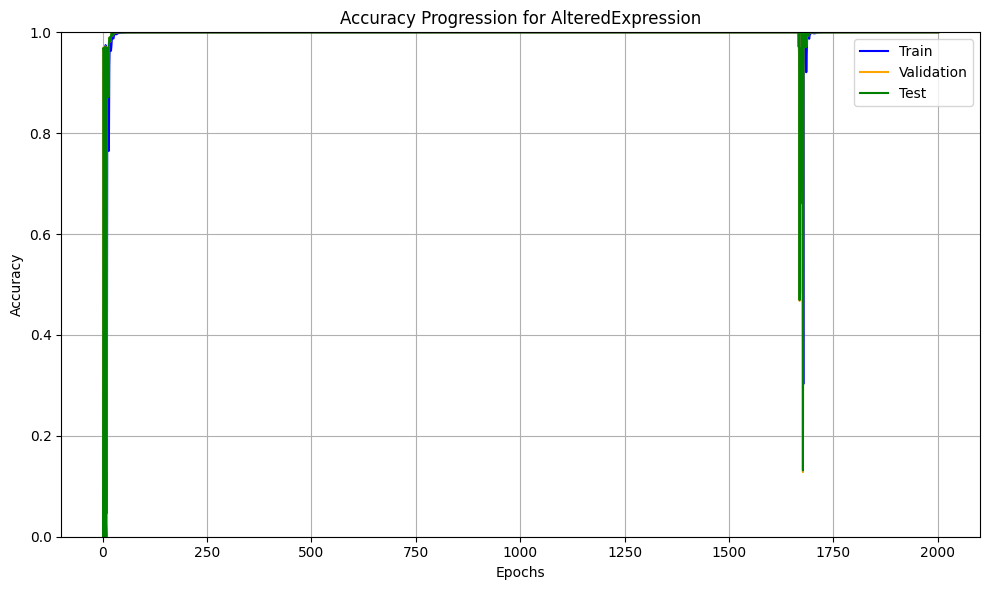

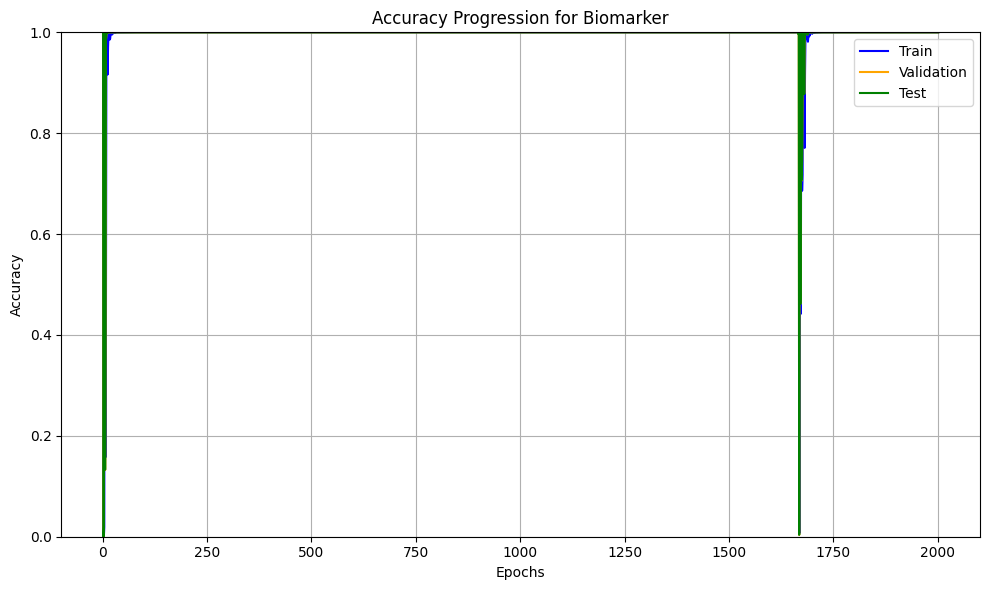

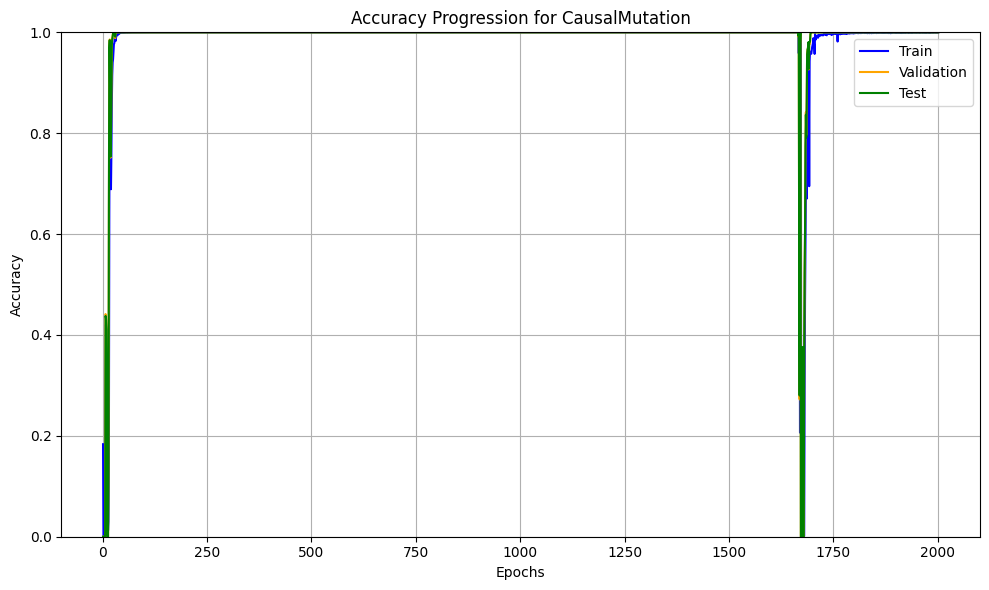

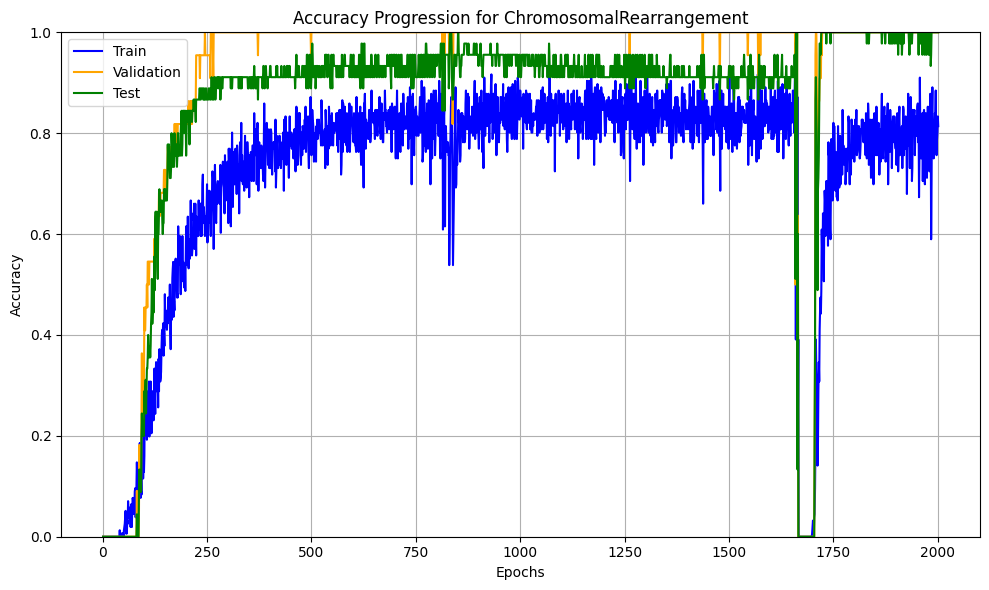

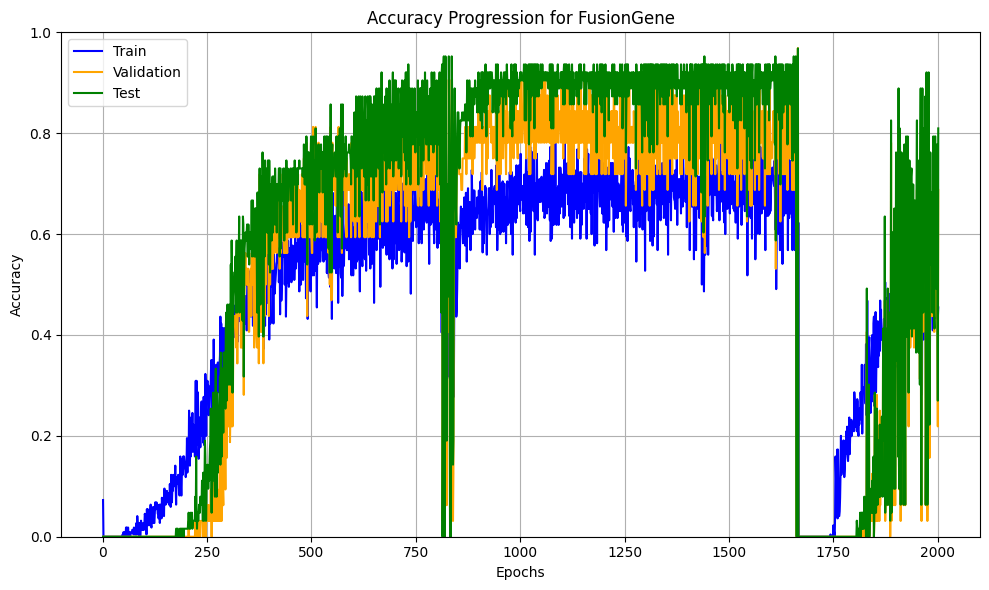

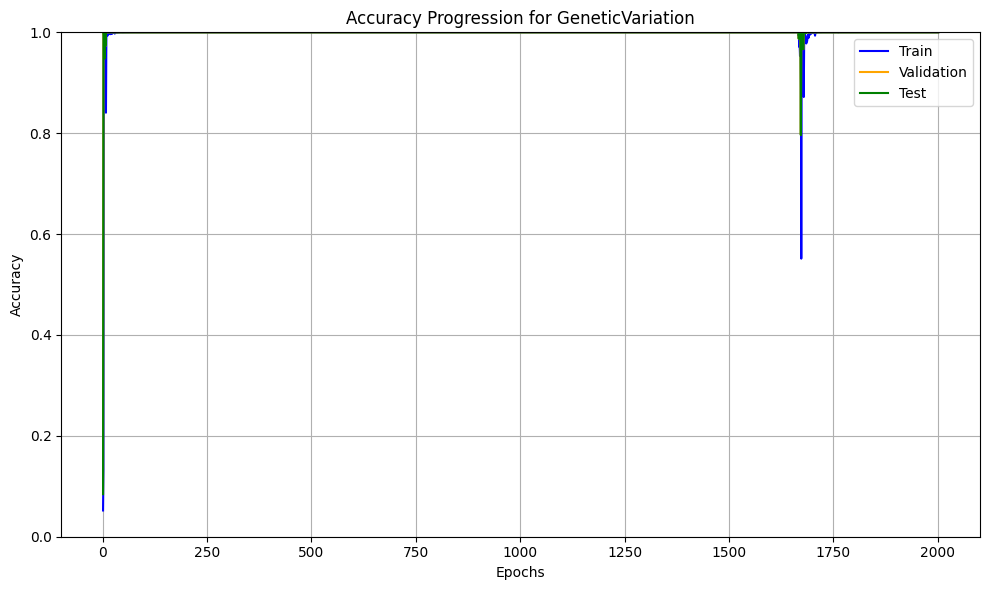

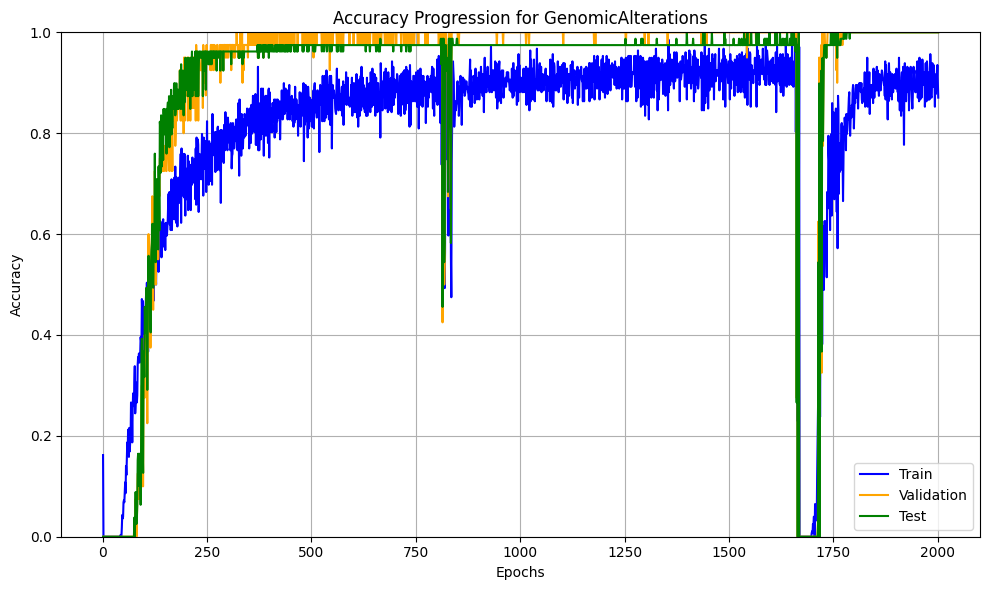

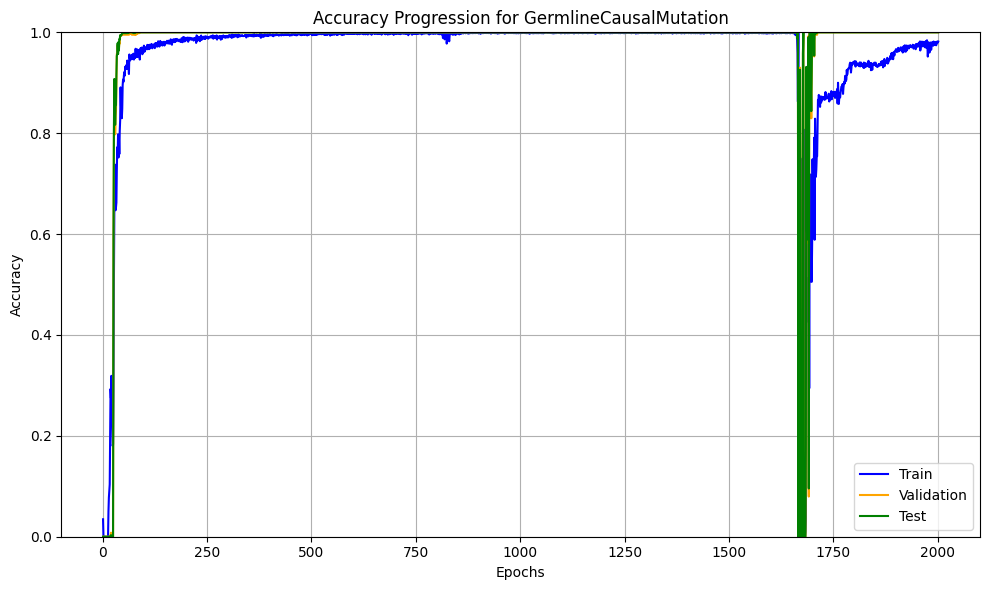

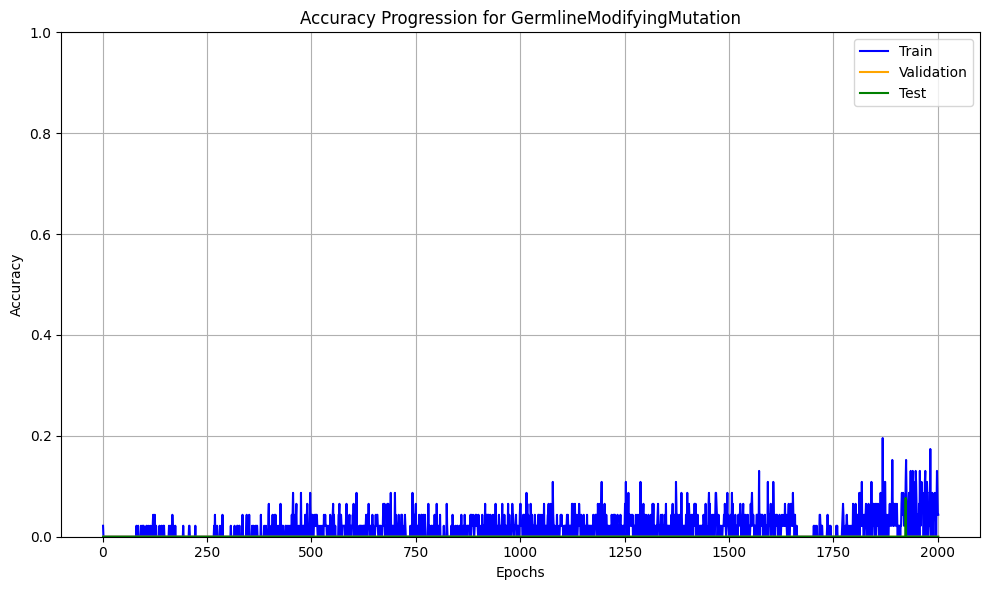

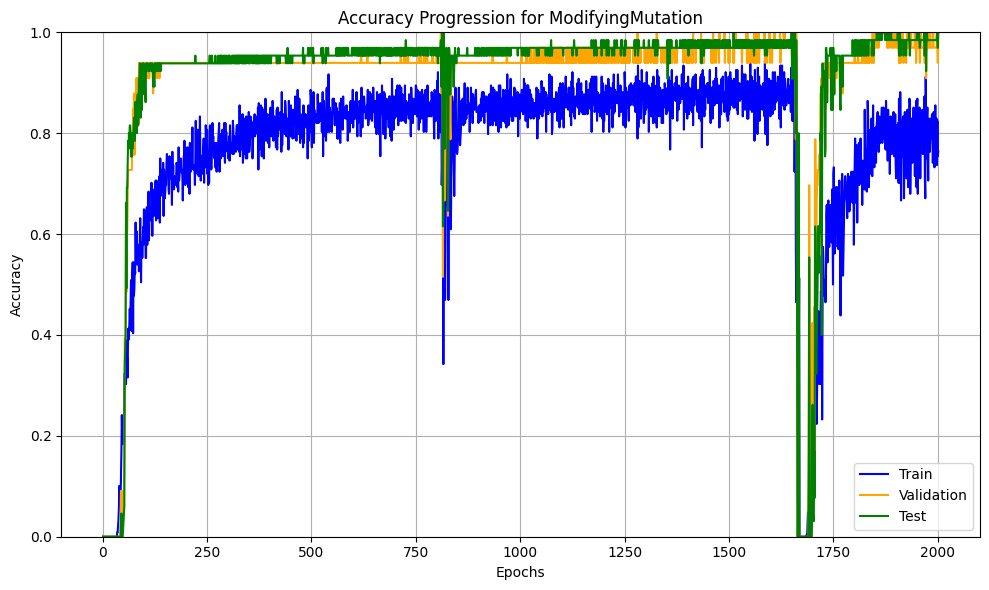

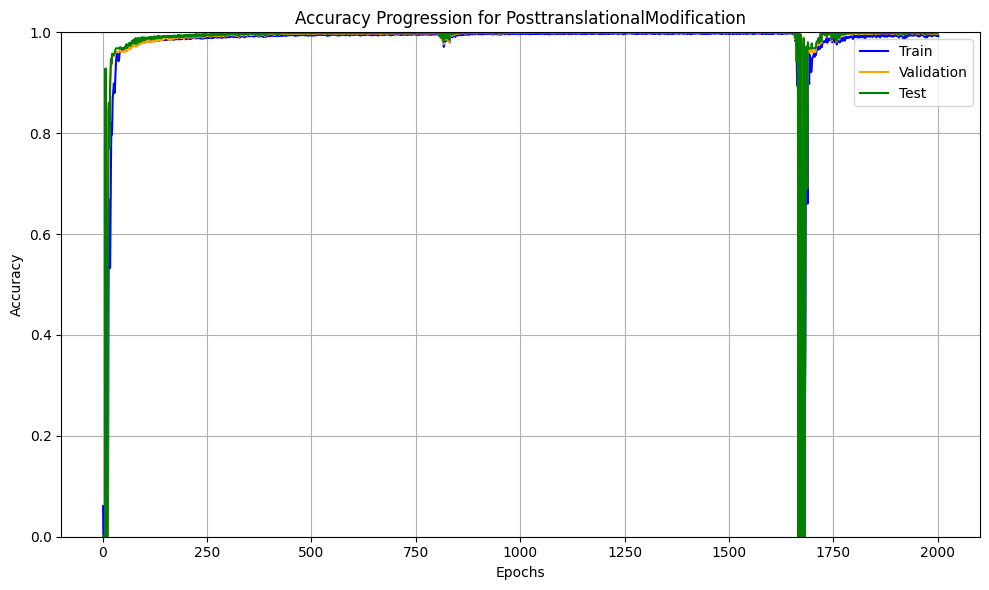

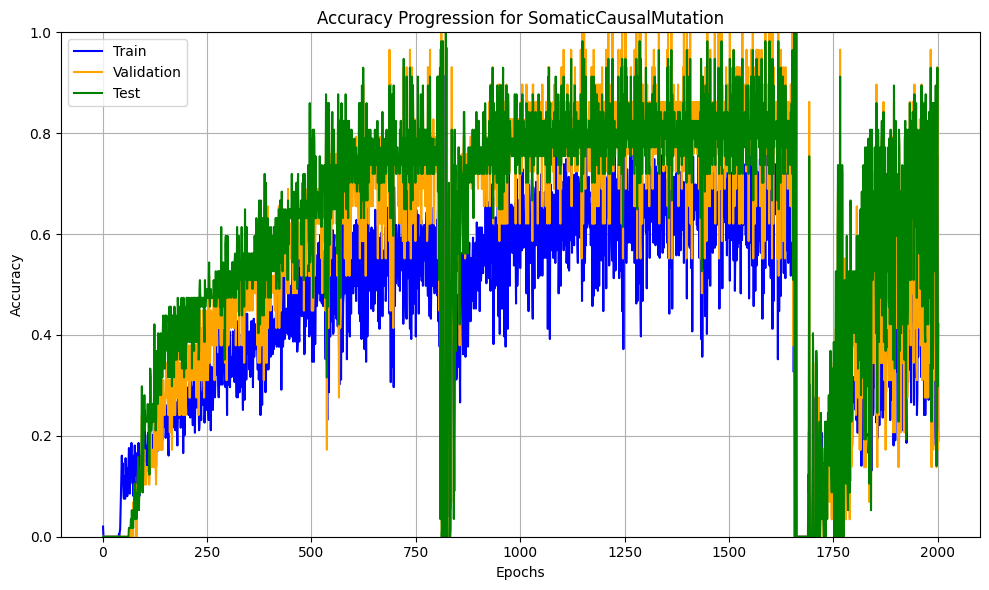

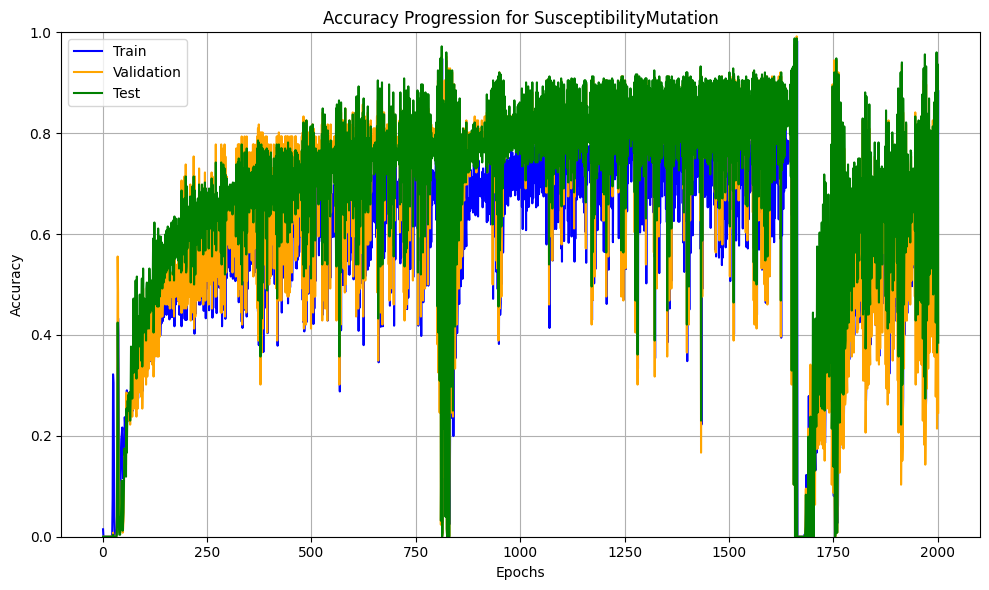

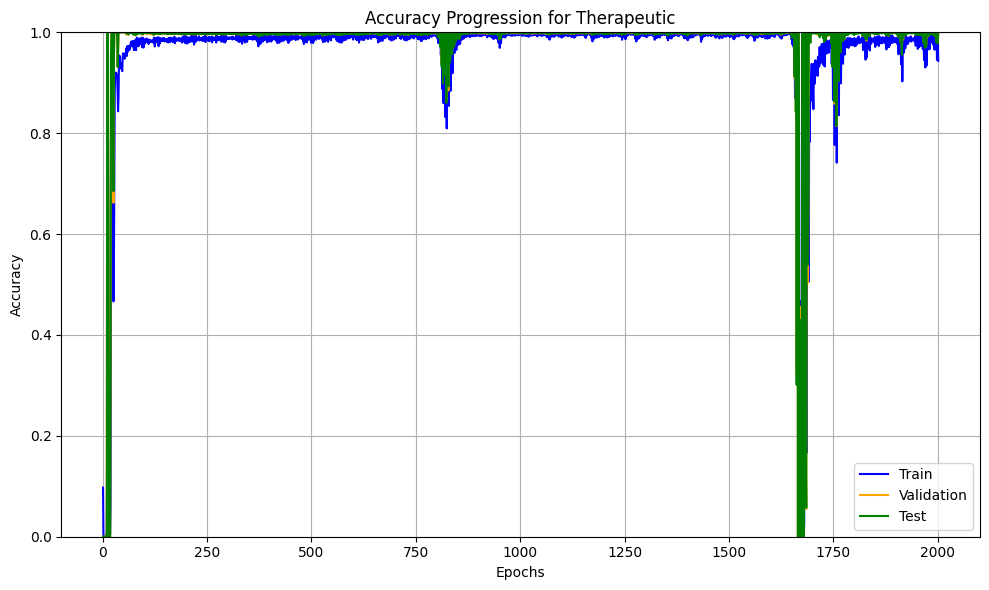

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, matthews_corrcoef, cohen_kappa_score
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

torch.cuda.empty_cache()

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)

def train(plot_pr_curve=False):
    model.train()
    total_loss = 0
    total_correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for batch_num, batch in enumerate(train_loader):
        start_batch_time = time.time()
        batch = batch.to(device)
        optimizer.zero_grad()
        x_dict, edge_index_dict = batch.x_dict, batch.edge_index_dict

        pred = model.decode(x_dict, batch['gene', 'associates', 'disease'].edge_index, batch['gene', 'associates', 'disease'].edge_attr)
        label = batch['gene', 'associates', 'disease'].edge_label

        pred_labels = hierarchical_classification(pred, hierarchy, new_thresholds, associationType_encoder)

        valid_mask = (label < len(associationType_encoder.classes_) - 2)
        pred_labels = pred_labels[valid_mask]
        label = label[valid_mask]

        correct_preds = pred_labels.eq(label).sum().item()

        total_correct += correct_preds
        total += label.size(0)
        all_preds.append(pred_labels.detach())
        all_labels.append(label.detach())

        if pred.size(0) > 0 and valid_mask.sum() > 0:
            pred = pred[valid_mask]
            loss = F.cross_entropy(pred, label)
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        print(f"[INFO] Batch {batch_num+1}/{len(train_loader)} processed in {time.time() - start_batch_time:.4f} seconds. Loss: {loss.item():.4f}")

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    precision, recall, f1, mcc, kappa = calculate_metrics_on_sample(all_preds, all_labels, sample_size=10000)
    
    valid_classes = len(associationType_encoder.classes_) - 2
    per_class_acc = accuracy_per_class(torch.tensor(all_preds), torch.tensor(all_labels), valid_classes)

    if plot_pr_curve:
        plot_precision_recall_curve(torch.tensor(all_labels), torch.tensor(all_preds), valid_classes, "Train Precision-Recall Curve")
        class_names = [encoded_to_name.get(i, f'Class {i}') for i in range(valid_classes)]
        plot_confusion_matrix(all_labels, all_preds, class_names, title="Train Confusion Matrix")

    return total_loss / len(train_loader), total_correct / total, precision, recall, f1, per_class_acc, mcc, kappa, all_preds

def test(loader, name, title="Precision-Recall Curve", plot_pr_curve=False):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_num, batch in enumerate(loader):
            batch = batch.to(device)
            x_dict, edge_index_dict = batch.x_dict, batch.edge_index_dict

            pred = model.decode(x_dict, batch['gene', 'associates', 'disease'].edge_index, batch['gene', 'associates', 'disease'].edge_attr)
            label = batch['gene', 'associates', 'disease'].edge_label
            
            pred_labels = hierarchical_classification(pred, hierarchy, new_thresholds, associationType_encoder)

            valid_mask = (label < len(associationType_encoder.classes_) - 2)
            pred_labels = pred_labels[valid_mask]
            label = label[valid_mask]

            correct_preds = pred_labels.eq(label).sum().item()

            total_correct += correct_preds
            total += label.size(0)
            all_preds.append(pred_labels)
            all_labels.append(label)
            
            if pred.size(0) > 0 and valid_mask.sum() > 0:
                pred = pred[valid_mask]
                loss = F.cross_entropy(pred, label)
                total_loss += loss.item()

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    precision, recall, f1, mcc, kappa = calculate_metrics_on_sample(all_preds, all_labels, sample_size=10000)

    valid_classes = len(associationType_encoder.classes_) - 2
    per_class_acc = accuracy_per_class(torch.tensor(all_preds), torch.tensor(all_labels), valid_classes)

    if plot_pr_curve:
        plot_precision_recall_curve(torch.tensor(all_labels), torch.tensor(all_preds), valid_classes, title)
        class_names = [encoded_to_name.get(i, f'Class {i}') for i in range(valid_classes)]
        plot_confusion_matrix(all_labels, all_preds, class_names, title=f"{name} Confusion Matrix")

    return total_loss / len(loader), total_correct / total, precision, recall, f1, per_class_acc, mcc, kappa, all_preds

train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
val_loader = DataLoader([val_data], batch_size=1)
test_loader = DataLoader([test_data], batch_size=1)

num_epochs = 2001

metrics = {
    'train_loss': [], 'train_acc': [], 'train_precision': [], 'train_recall': [], 'train_f1': [], 'train_mcc': [], 'train_kappa': [],
    'val_loss': [], 'val_acc': [], 'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_mcc': [], 'val_kappa': [],
    'test_loss': [], 'test_acc': [], 'test_precision': [], 'test_recall': [], 'test_f1': [], 'test_mcc': [], 'test_kappa': [],
    'train_class_acc': {i: [] for i in range(len(associationType_encoder.classes_) - 2)},
    'val_class_acc': {i: [] for i in range(len(associationType_encoder.classes_) - 2)},
    'test_class_acc': {i: [] for i in range(len(associationType_encoder.classes_) - 2)}
}

all_preds_dict = {
    'train': [],
    'val': [],
    'test': []
}

for epoch in range(num_epochs):
    print(f"\n[INFO] Starting epoch {epoch + 1}/{num_epochs}")
    epoch_start_time = time.time()

    plot_pr_curve = (epoch == num_epochs - 1)

    train_loss, train_acc, train_precision, train_recall, train_f1, train_class_acc, train_mcc, train_kappa, train_preds = train(plot_pr_curve=plot_pr_curve)
    
    val_loss, val_acc, val_precision, val_recall, val_f1, val_class_acc, val_mcc, val_kappa, val_preds = test(val_loader, "Validation", "Validation Precision-Recall Curve", plot_pr_curve=plot_pr_curve)

    test_loss, test_acc, test_precision, test_recall, test_f1, test_class_acc, test_mcc, test_kappa, test_preds = test(test_loader, "Test", "Test Precision-Recall Curve", plot_pr_curve=plot_pr_curve)
 
    all_preds_dict['train'].append(train_preds.tolist())
    all_preds_dict['val'].append(val_preds.tolist())
    all_preds_dict['test'].append(test_preds.tolist())
    
    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['train_precision'].append(train_precision)
    metrics['train_recall'].append(train_recall)
    metrics['train_f1'].append(train_f1)
    metrics['train_mcc'].append(train_mcc)
    metrics['train_kappa'].append(train_kappa)

    metrics['val_loss'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    metrics['val_precision'].append(val_precision)
    metrics['val_recall'].append(val_recall)
    metrics['val_f1'].append(val_f1)
    metrics['val_mcc'].append(val_mcc)
    metrics['val_kappa'].append(val_kappa)

    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc)
    metrics['test_precision'].append(test_precision)
    metrics['test_recall'].append(test_recall)
    metrics['test_f1'].append(test_f1)
    metrics['test_mcc'].append(test_mcc)
    metrics['test_kappa'].append(test_kappa)
    
    valid_classes = len(associationType_encoder.classes_) - 2
    for class_idx in range(valid_classes):
        metrics['train_class_acc'][class_idx].append(train_class_acc[f'Class {class_idx}'])
        metrics['val_class_acc'][class_idx].append(val_class_acc[f'Class {class_idx}'])
        metrics['test_class_acc'][class_idx].append(test_class_acc[f'Class {class_idx}'])

    if(epoch % 10 ==0):
        print(f'Epoch {epoch + 1} completed in {time.time() - epoch_start_time:.2f} seconds.')
        print(f'Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1: {train_f1:.4f}, MCC: {train_mcc:.4f}, Kappa: {train_kappa:.4f}')
        print('Train Class Acc:', {k: f'{v:.4f}' for k, v in train_class_acc.items()})
        print(f'Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}, MCC: {val_mcc:.4f}, Kappa: {val_kappa:.4f}')
        print('Val Class Acc:', {k: f'{v:.4f}' for k, v in val_class_acc.items()})
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}, Kappa: {test_kappa:.4f}')
        print('Test Class Acc:', {k: f'{v:.4f}' for k, v in test_class_acc.items()})
        print('\n')

plot_class_distribution(geneDiseaseNetwork, encoded_to_name)
plot_class_accuracies(train_class_acc, val_class_acc, test_class_acc, len(associationType_encoder.classes_), encoded_to_name)

plot_training_metrics(metrics)

class_names = {i: encoded_to_name.get(i, f'Class {i}') for i in range(len(associationType_encoder.classes_) - 2)}

plot_class_accuracies_per_classes(metrics, len(associationType_encoder.classes_) - 2, class_names)

import json

with open('gnn_metrics_tracking.json', 'w') as f:
    json.dump(metrics, f, indent=4)

with open('gnn_all_preds.json', 'w') as f:
    json.dump(all_preds_dict, f, indent=4)